In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 10.9MB/s 
     |████████████████████████████████| 194kB 23.6MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 1.2MB 13.3MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
Mounted at /content/gdrive


In [4]:
!pip install -q kaggle
!pip install dtreeviz
!mkdir -p ~/.kaggle
!cp gdrive/MyDrive/kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 51kB 4.5MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.1.4-cp36-none-any.whl size=53568 sha256=27916ce1fe12486285f8d033357a8fb548e0c83deed9394330fd1231232e2299
  Stored in directory: /root/.cache/pip/wheels/6a/1b/01/8d804e4d3cf01cf38097a756b02c851a032c09e3a25feb7c50
Successfully built dtreeviz
kaggle.json


In [5]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Modeling Deep Dive

## Categorical Embeddings

## Beyond Deep Learning

## The Dataset

### Kaggle Competitions

In [6]:
creds = ''

In [7]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write(creds)
    cred_path.chmod(0o600)

In [8]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [9]:
#hide
Path.BASE_PATH = path

In [10]:
!ls /root/.fastai/

config.yml


In [11]:
if not path.exists():
    path.mkdir(parents=True)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

  0%|          | 0.00/48.4M [00:00<?, ?B/s]

100%|██████████| 48.4M/48.4M [00:00<00:00, 61.1MB/s]


(#7) [Path('Valid.csv'),Path('random_forest_benchmark_test.csv'),Path('median_benchmark.csv'),Path('Machine_Appendix.csv'),Path('ValidSolution.csv'),Path('Test.csv'),Path('TrainAndValid.csv')]

### Look at the Data

In [12]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [13]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [14]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [15]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [16]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [22]:
df['ProductSize'].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

In [23]:
df['ProductSize'].unique()

[NaN, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

In [24]:
dep_var = 'SalePrice'

In [25]:
df[dep_var] = np.log(df[dep_var])

## XGBoost


In [142]:
import xgboost as xgb

In [143]:
from sklearn import metrics
from sklearn import preprocessing

In [147]:
features=[f for f in df.columns if f not in ('SalePrice')]

In [149]:
df_xgb=df.copy()

In [150]:
for col in features:
  df_xgb.loc[:,col]=df_xgb[col].astype(str).fillna('NONE')

In [152]:
for col in features:
  lbl=preprocessing.LabelEncoder()
  lbl.fit(df_xgb[col])
  df_xgb.loc[:,col]=lbl.transform(df_xgb[col])

In [153]:
model_xgb=xgb.XGBRegressor(n_jobs=-1,max_depth=7,n_estimators=100)

In [ ]:
model_xgb.fit()

## Decision Trees

### Handling Dates

In [26]:
df = add_datepart(df, 'saledate')

In [27]:
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [28]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleWeek saleYear saleMonth saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

### Using TabularPandas and TabularProc

In [29]:
df['saleWeek']=df['saleWeek'].astype(np.int32)

In [30]:
np.issubdtype(df['saleWeek'].dtype,np.integer)

True

In [31]:
procs = [Categorify, FillMissing]

In [32]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [33]:
pd.__version__

'1.1.5'

In [34]:
np.__version__

'1.19.5'

In [36]:
??cont_cat_split

In [37]:
def cont_cat_split2(df, max_card=20, dep_var=None):
    "Helper function that returns column names of cont and cat variables from given `df`."
    cont_names, cat_names = [], []
    for label in df:
      try:
        if label in L(dep_var): continue
        if (np.issubdtype(df[label].dtype, np.integer) and
            df[label].unique().shape[0] > max_card or
            np.issubdtype(df[label].dtype, np.floating)):
            cont_names.append(label)
        else: cat_names.append(label)
      except:
        cat_names.append(label)
    return cont_names, cat_names

In [38]:
#cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
cont,cat =cont_cat_split2(df, 1, dep_var=dep_var)

In [39]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [40]:
len(to.train),len(to.valid)

(404710, 7988)

In [41]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,saleWeek,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,46,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,13,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,9,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [42]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [43]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,...,1,2647,1,1
1,1139248,10.950807,117657,13,...,1,2148,1,1
2,1139249,9.210340,434808,9,...,1,2131,1,1


In [44]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [45]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [46]:
#(path/'to.pkl').save(to)
with (path/'to.pkl').open('wb') as fp:
    pickle.dump(to, fp)

### Creating the Decision Tree

In [47]:
#hide
#to = (path/'to.pkl').load()
with (path/'to.pkl').open('rb') as fp:
    to=pickle.load(fp)

In [48]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [49]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

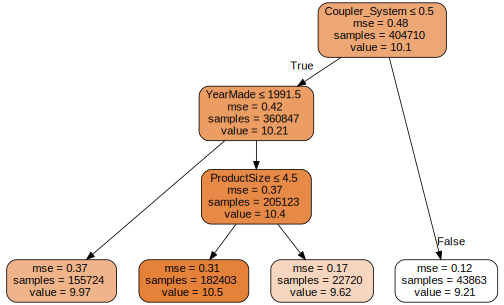

In [50]:
draw_tree(m, xs, size=7, leaves_parallel=True, precision=2)

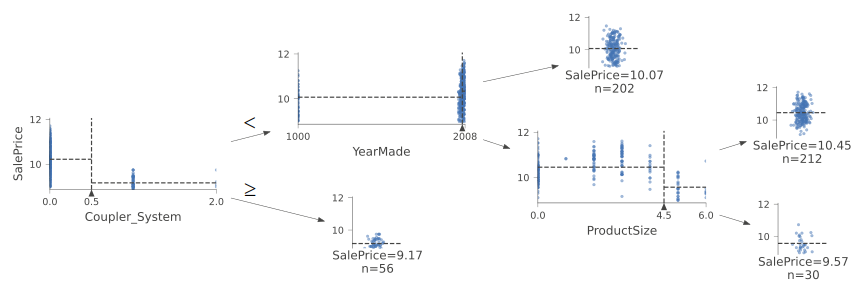

In [51]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [52]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

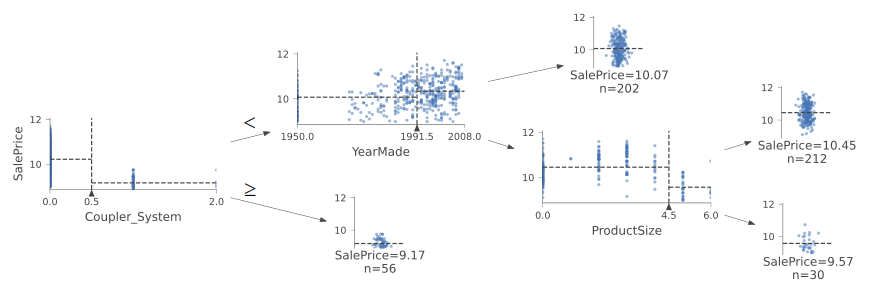

In [53]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [54]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [55]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [56]:
m_rmse(m, xs, y)

1e-06

In [57]:
m_rmse(m, valid_xs, valid_y)

0.333112

In [58]:
m.get_n_leaves(), len(xs)

(324565, 404710)

In [59]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248595, 0.323399)

In [60]:
m.get_n_leaves()

12397

### Categorical Variables

## Random Forests

In [61]:
#hide
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

### Creating a Random Forest

In [62]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [63]:
m = rf(xs, y);

In [64]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170808, 0.232406)

In [65]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [66]:
r_mse(preds.mean(0), valid_y)

0.232406

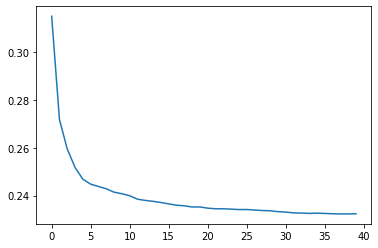

In [67]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

### Out-of-Bag Error

In [68]:
r_mse(m.oob_prediction_, y)

0.21052

## Model Interpretation

### Tree Variance for Prediction Confidence

In [69]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [70]:
preds.shape

(40, 7988)

In [71]:
preds_std = preds.std(0)

In [72]:
preds_std[:5]

array([0.20852237, 0.11403559, 0.09531696, 0.23696253, 0.11246767])

### Feature Importance

In [73]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [74]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.171312
30,Coupler_System,0.119788
6,ProductSize,0.114872
7,fiProductClassDesc,0.068519
56,ModelID,0.054451
3,fiSecondaryDesc,0.053365
50,saleElapsed,0.050239
12,Enclosure,0.038051
31,Grouser_Tracks,0.037815
32,Hydraulics_Flow,0.032734


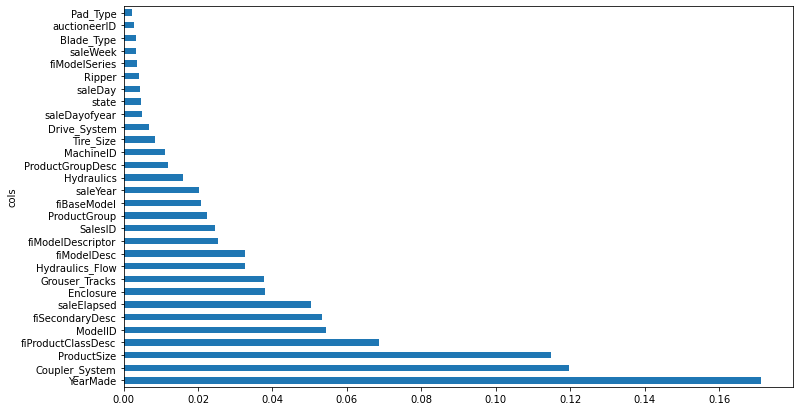

In [75]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

In [76]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [77]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [78]:
m = rf(xs_imp, y)

In [79]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181104, 0.230574)

In [80]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

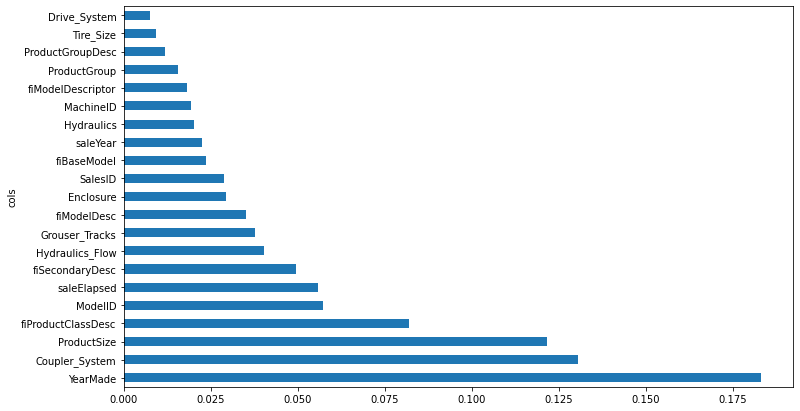

In [81]:
plot_fi(rf_feat_importance(m, xs_imp));

### Removing Redundant Features

In [82]:
??cluster_columns

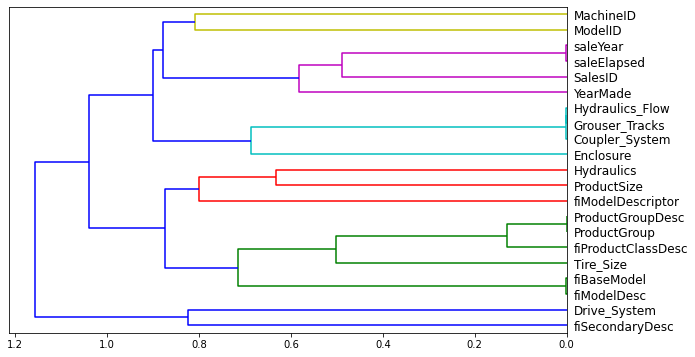

In [83]:
cluster_columns(xs_imp)

In [84]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [85]:
get_oob(xs_imp)

0.8764410377988594

In [86]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8778145616354095,
 'Grouser_Tracks': 0.8772923083390904,
 'Hydraulics_Flow': 0.8778530782106663,
 'ProductGroup': 0.8767961703098911,
 'ProductGroupDesc': 0.8773236585083313,
 'fiBaseModel': 0.8756228700540764,
 'fiModelDesc': 0.8763622619440036,
 'saleElapsed': 0.8720694164876017,
 'saleYear': 0.8761576456556869}

In [87]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8751218470772454

In [88]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [89]:
with (path/'xs_final.pkl').open('wb') as fx:
  pickle.dump(xs_final,fx)
with (path/'valid_xs_final.pkl').open('wb') as fy:
  pickle.dump(valid_xs_final,fy)

In [90]:
with (path/'xs_final.pkl').open('rb') as fx:
  xs_final=pickle.load(fx)
with (path/'valid_xs_final.pkl').open('rb') as fy:
  valid_xs_final=pickle.load(fy)

# xs_final = (path/'xs_final.pkl').load()
# valid_xs_final = (path/'valid_xs_final.pkl').load()

In [91]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183382, 0.23278)

### Partial Dependence

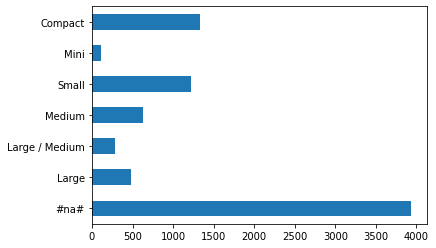

In [92]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

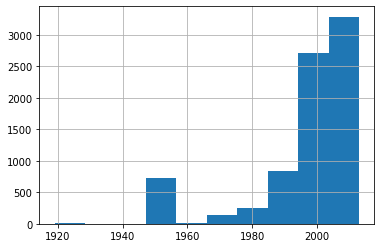

In [93]:
ax = valid_xs_final['YearMade'].hist()

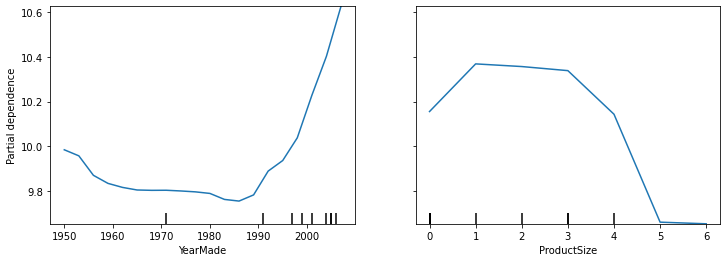

In [94]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

### Data Leakage

### Tree Interpreter

In [95]:
!pip install treeinterpreter

In [96]:
!pip install waterfallcharts

  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-cp36-none-any.whl size=3413 sha256=efbeddfa2fb0beb9573ae319f395e6a1aa024d3bb842e91317a97337fb94bdb0
  Stored in directory: /root/.cache/pip/wheels/f9/be/d0/59ccb7fc5d874cbea7cbfcf89e42feccfe8fa18a90a1bf4370
Successfully built waterfallcharts


In [97]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [98]:
row = valid_xs_final.iloc[:5]

In [102]:
m

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=200000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [103]:
prediction,bias,contributions = treeinterpreter.predict(m, row.values)

In [104]:
prediction[0], bias[0], contributions[0].sum()

(array([10.01255406]), 10.104746057831763, -0.092191998676771)

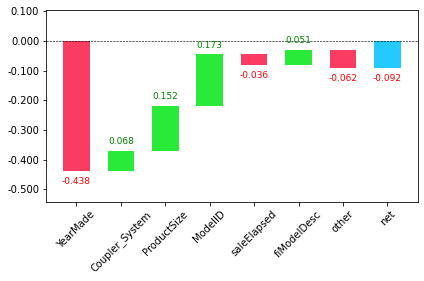

In [105]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

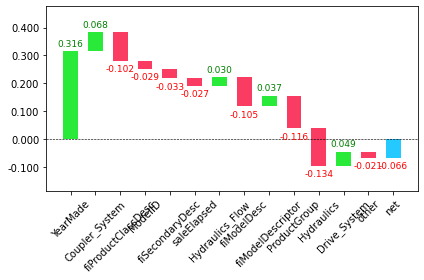

In [106]:
waterfall(valid_xs_final.columns, contributions[1], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Extrapolation and Neural Networks

### The Extrapolation Problem

In [107]:
#hide
np.random.seed(42)

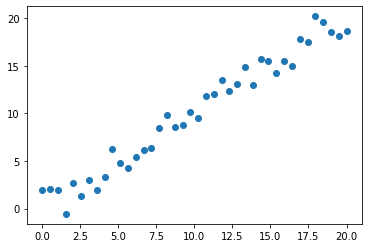

In [108]:
x_lin = torch.linspace(0,20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [109]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape,xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [110]:
x_lin[:,None].shape

torch.Size([40, 1])

In [111]:
m_lin = RandomForestRegressor().fit(xs_lin[:30],y_lin[:30])

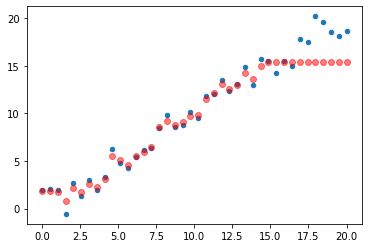

In [112]:
plt.scatter(x_lin, y_lin, 20)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

### Finding Out-of-Domain Data

In [113]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
6,saleElapsed,0.904446
11,SalesID,0.070529
14,MachineID,0.020080
0,YearMade,0.001697
15,Tire_Size,0.000548
13,Hydraulics,0.000527


In [114]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))

for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

orig 0.232436
SalesID 0.23066
saleElapsed 0.235298
MachineID 0.231625


In [115]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_time, valid_y)

0.228595

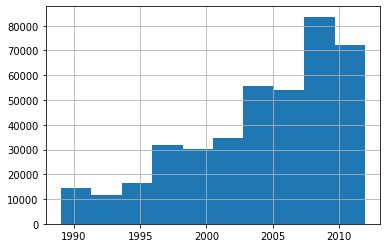

In [124]:
xs['saleYear'].hist();

In [125]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [126]:
m = rf(xs_filt, y_filt)
m_rmse(m, xs_filt, y_filt), m_rmse(m, valid_xs_time, valid_y)

(0.177588, 0.229683)

### Using a Neural Network

In [116]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [117]:
xs_final_time.columns

Index(['YearMade', 'Coupler_System', 'ProductSize', 'fiProductClassDesc',
       'ModelID', 'fiSecondaryDesc', 'saleElapsed', 'Enclosure',
       'Hydraulics_Flow', 'fiModelDesc', 'fiModelDescriptor', 'ProductGroup',
       'Hydraulics', 'Tire_Size', 'Drive_System'],
      dtype='object')

In [118]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [119]:
#cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)
cont_nn,cat_nn = cont_cat_split2(df_nn_final, max_card=9000, dep_var=dep_var)

In [120]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [121]:
df_nn_final[cat_nn].nunique()

YearMade                73
Coupler_System           2
ProductSize              6
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
fiModelDescriptor      140
ProductGroup             6
Hydraulics              12
Tire_Size               17
Drive_System             4
dtype: int64

In [127]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)


In [128]:
m_rmse(m2, valid_xs_time2, valid_y)

0.229976

In [129]:
#m_rmse(m, xs_filt2, y_filt)

In [130]:
cat_nn.remove('fiModelDescriptor')

In [131]:
df_nn_final


,YearMade,Coupler_System,ProductSize,fiProductClassDesc,...,Hydraulics,Tire_Size,Drive_System,SalePrice
0,2004,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,...,2 Valve,None or Unspecified,NaN,11.097410
1,1996,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,...,2 Valve,23.5,NaN,10.950807
2,2001,None or Unspecified,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,...,Auxiliary,NaN,NaN,9.210340
3,2001,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",...,2 Valve,NaN,NaN,10.558414
4,2007,None or Unspecified,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,...,Auxiliary,NaN,NaN,9.305651
...,...,...,...,...,...,...,...,...,...
412693,2005,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons",...,Standard,NaN,NaN,9.210340
412694,2005,NaN,Mini,"Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons",...,Auxiliary,NaN,NaN,9.259131
412695,2005,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons",...,Auxiliary,NaN,NaN,9.433484
412696,2006,NaN,Mini,"Hydraulic Excavator, Track - 2.0 to 3.0 Metric Tons",...,Auxiliary,NaN,NaN,9.210340


In [132]:
#procs_nn = [Categorify, FillMissing, Normalize]
#Normalize seems not work
procs_nn = [Categorify, FillMissing]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [133]:
dls = to_nn.dataloaders(1024)

In [134]:
y = to_nn.train.y
y.min(),y.max()

(8.465899467468262, 11.863582611083984)

In [135]:
from fastai.tabular.all import *

In [136]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.0002754228771664202)

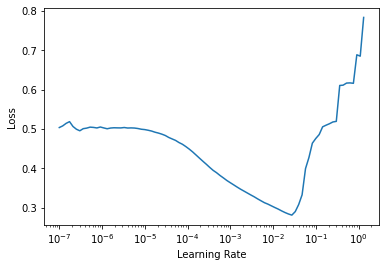

In [137]:
learn.lr_find()

In [138]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.068906,0.061510,00:11
1,0.056020,0.057748,00:11
2,0.048998,0.056871,00:11
3,0.043923,0.051501,00:11
4,0.040681,0.051060,00:11


In [139]:
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.225965

In [140]:
learn.save('nn')

Path('models/nn.pth')

### Sidebar: fastai's Tabular Classes

### End sidebar

## Ensembling

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

In [ ]:
r_mse(ens_preds,valid_y)

0.222495

### Boosting

### Combining Embeddings with Other Methods

## Conclusion: Our Advice for Tabular Modeling

## Questionnaire

1. What is a continuous variable?
1. What is a categorical variable?
1. Provide two of the words that are used for the possible values of a categorical variable.
1. What is a "dense layer"?
1. How do entity embeddings reduce memory usage and speed up neural networks?
1. What kinds of datasets are entity embeddings especially useful for?
1. What are the two main families of machine learning algorithms?
1. Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?
1. Summarize what a decision tree algorithm does.
1. Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick?
1. What is pickle and what is it useful for?
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?
1. How do we deal with outliers, before building a decision tree?
1. How do we handle categorical variables in a decision tree?
1. What is bagging?
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?
1. In the section "Creating a Random Forest", just after <<max_features>>, why did `preds.mean(0)` give the same result as our random forest?
1. What is "out-of-bag-error"?
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?
1. Explain why random forests are well suited to answering each of the following question:
   - How confident are we in our predictions using a particular row of data?
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?
   - Which columns are the strongest predictors?
   - How do predictions vary as we vary these columns?
1. What's the purpose of removing unimportant variables?
1. What's a good type of plot for showing tree interpreter results?
1. What is the "extrapolation problem"?
1. How can you tell if your test or validation set is distributed in a different way than your training set?
1. Why do we make `saleElapsed` a continuous variable, even although it has less than 9,000 distinct values?
1. What is "boosting"?
1. How could we use embeddings with a random forest? Would we expect this to help?
1. Why might we not always use a neural net for tabular modeling?

### Further Research

1. Pick a competition on Kaggle with tabular data (current or past) and try to adapt the techniques seen in this chapter to get the best possible results. Compare your results to the private leaderboard.
1. Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the datase you used in the first exercise.
1. Use the embeddings from the neural net in this chapter in a random forest, and see if you can improve on the random forest results we saw.
1. Explain what each line of the source of `TabularModel` does (with the exception of the `BatchNorm1d` and `Dropout` layers).